## Noise-Based Probe

This notebook demonstrates the *Noise-Based Probe*, a training-free method for evaluating whether erased concepts can be recovered during generation. 
It builds on the insight that DDIM sampling includes a stochastic noise term that influences trajectory diversity when $\sigma_t > 0$.

By scaling this noise using a factor $\eta$, we inject progressively more noise into the generation process to explore alternate trajectories. 
If increasing $\eta$ causes the erased concept to reappear, this suggests that the erased model still retains latent capacity to regenerate the concept—indicating incomplete erasure.

### Modified DDIM Formulation with Noise Injection

We modify the DDIM update step by sweeping values for the noise injection factor $\eta$, introducing an additional **noise direction scaler** $v$, and applying an absolute value around the direction term for numerical stability:

$$
x_{t-1} = \sqrt{\alpha_{t-1}} \left( \frac{x_t - \sqrt{1 - \alpha_t}\,\epsilon_\theta^{(t)}(x_t)}{\sqrt{\alpha_t}} \right)
+ \sqrt{ \left| 1 - \alpha_{t-1} -  \eta \cdot \sigma_t^2 \right| }\,\epsilon_\theta^{(t)}(x_t)
+ v \cdot \eta \cdot \sigma_t\,\epsilon_t
$$

- The **first term** deterministically predicts $x_{t-1}$ from $x_t$ and the predicted noise.
- The **second term** (scaled by $eta$) controls the magnitude of the step toward $x_t$ (wrapped in a new absolute value to avoid NaNs).
- The **third term** (scaled by $\eta$ and $v$) introduces additional stochasticity via random noise $\epsilon_t \sim \mathcal{N}(0, I)$.

By sweeping over values of $v$ and $\eta$, we can probe whether erased concepts are truly absent, or simply require more noise to reappear—thereby testing the resilience of erasure across the model’s generative manifold.


Using device: cuda


Loading pipeline components...: 100%|██████████| 7/7 [00:12<00:00,  1.78s/it]


✅ ESD-X model loaded successfully!


100%|██████████| 50/50 [00:01<00:00, 27.35it/s]


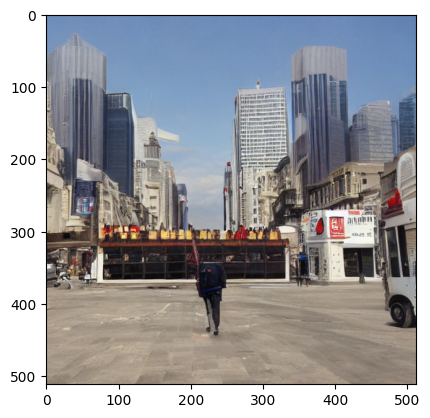

In [2]:
import torch
import os
os.environ["TQDM_NOTEBOOK"] = "false"
from diffusers import StableDiffusionPipeline
import matplotlib.pyplot as plt
import warnings
import warnings
warnings.filterwarnings("ignore", message=".*IProgress not found.*")

# Check for GPU availability (MPS for Apple Silicon or CUDA for NVIDIA GPUs)
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# Load the ESD-X model from Hugging Face
model_id = "ErasureResearch/esdx_airliner"

pipeline = StableDiffusionPipeline.from_pretrained(
    model_id,
    torch_dtype=torch.float16 if device != "cpu" else torch.float32,  # Use FP16 for GPU, FP32 for CPU
    use_safetensors=True
).to(device)

print("✅ ESD-X model loaded successfully!")

# Sample text prompt for generation
prompt = "An airliner"

# Inference
with torch.inference_mode():
    image = pipeline(prompt).images[0]

plt.imshow(image)


## Applying the Noise-Based Probe

In [14]:
import matplotlib.pyplot as plt
from tqdm import tqdm
from noisy_diffuser_scheduling.schedulers.eta_ddim_scheduler import DDIMScheduler
pipeline.scheduler = DDIMScheduler.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="scheduler")

# List of eta and variance scale values
etas =  [1.0, 1.17, 1.34, 1.51, 1.68, 1.85]
variance_scales = [1.0, 1.02, 1.03, 1.04]

# Initialize an empty list to store images and labels
images = []
labels = []
pipeline.safety_checker = None

# Total number of combinations
total_combinations = len(etas) * len(variance_scales)

# Iterate through eta values and variance scales to generate images with tqdm
with tqdm(total=total_combinations, desc="Generating Images") as pbar:
    for eta in etas:
        for variance_scale in variance_scales:
            image = pipeline("a picture of an airliner", eta=eta, variance_scale=variance_scale, seed=1000).images[0]
            images.append(image)
            labels.append(f"eta={eta}\nv_scale={variance_scale}")
            pbar.update(1)

# Calculate grid dimensions

Generating Images:   0%|          | 0/24 [00:00<?, ?it/s]

Generating Images: 100%|██████████| 24/24 [00:47<00:00,  1.99s/it]


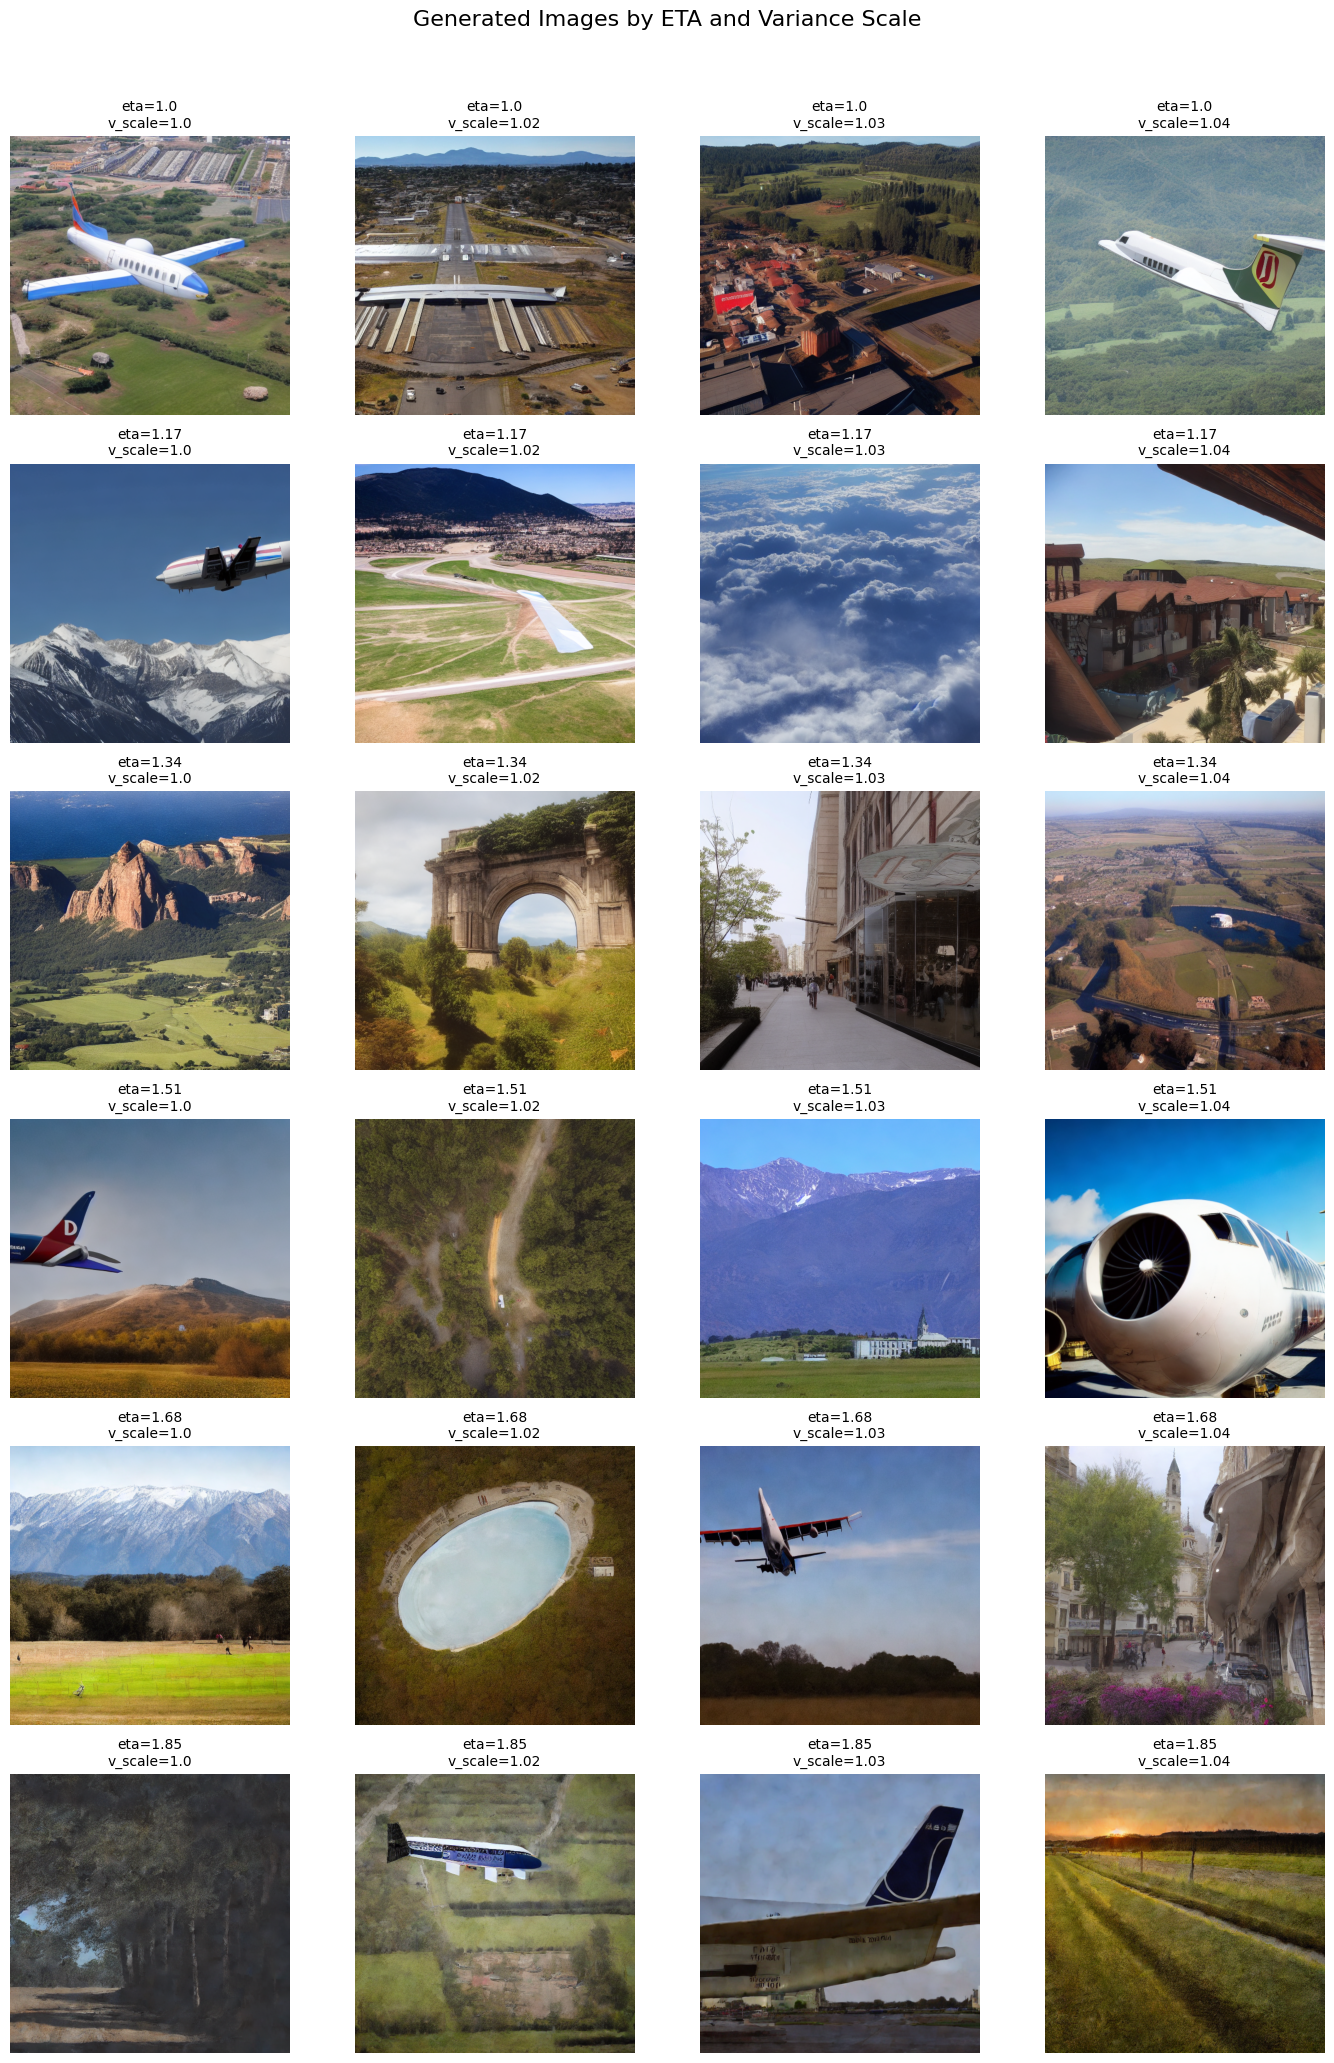

In [15]:
# Grid dimensions
rows = len(etas)  # eta on Y-axis
cols = len(variance_scales)  # variance_scale on X-axis

fig, axes = plt.subplots(rows, cols, figsize=(3.5 * cols, 3.5 * rows))
fig.suptitle("Generated Images by ETA and Variance Scale", fontsize=16)

# Plot images
for idx, (img, label) in enumerate(zip(images, labels)):
    row = idx // cols
    col = idx % cols
    ax = axes[row, col]
    ax.imshow(img)
    ax.set_title(label, fontsize=10)
    ax.axis("off")

plt.tight_layout()
plt.subplots_adjust(top=0.92)  # make room for suptitle
plt.show()

In [16]:
import torch
from PIL import Image
from transformers import CLIPProcessor, CLIPModel

def get_best_image(images, prompt):
    """
    Given a list of images and a prompt, returns the image with the highest CLIP score.

    Args:
        images (list): List of PIL Image objects or paths to image files.
        prompt (str): The text prompt to compare against the images.

    Returns:
        PIL.Image: Image with the highest CLIP score.
    """
    # Load CLIP model and processor
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
    model = model.to(device)
    processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

    # Ensure all images are PIL images
    pil_images = [Image.open(img) if isinstance(img, str) else img for img in images]

    # Encode inputs
    inputs = processor(text=[prompt], images=pil_images, return_tensors="pt", padding=True).to(device)

    # Calculate CLIP scores
    with torch.no_grad():
        outputs = model(**inputs)
        logits_per_image = outputs.logits_per_image

    # Get the best image index
    best_idx = logits_per_image.argmax().item()

    return pil_images[best_idx]


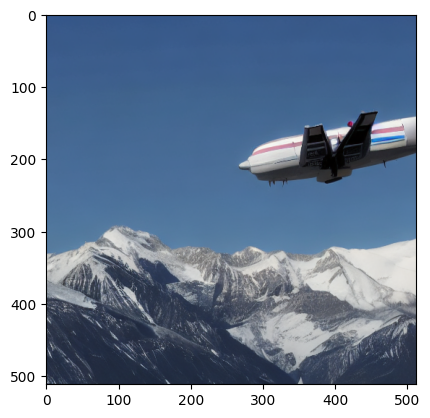

In [17]:
plt.imshow(get_best_image(images, "airliner"))